In [1]:
import torch.onnx
import torchvision
import torch
import numpy as np
from torch.autograd import Variable
from model import Discriminator, Generator
from config import Config
from thermal_dataset import ThermalImageDataset as ImageDataset
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import scipy.misc
from torchvision.utils import save_image

In [2]:
config = Config(mode='valid',exp_name="2022-04-26-VaillaSRGAN")
model = Generator()
model.load_state_dict(torch.load(config.model_path))
model.to(config.device)
model.eval()

Generator(
  (conv_block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (trunk): Sequential(
    (0): ResidualConvBlock(
      (rcb): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualConvBlock(
      (rcb): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

In [3]:
def plot_result(high_img,sr_img, lr_img, baseline="INTER_LANCZOS4"):

    # Baseline = Bilinear
    if type(baseline) == str:
        low_img_baseline = cv2.resize(lr_img,dsize=(0,0),fx=4,fy=4,interpolation=getattr(cv2,baseline))
    else:
        low_img_baseline = cv2.resize(lr_img,dsize=(0,0),fx=4,fy=4,interpolation=baseline)
                                  
    f, axarr = plt.subplots(1,4, figsize=(16,8))
    axarr[0].imshow(high_img, interpolation='none', cmap='gray')
    axarr[0].set_title("Target (HR)")

    axarr[1].imshow(sr_img, interpolation='none', cmap='gray')
    axarr[1].set_title("Our result (SRGAN)")

    axarr[2].imshow(low_img_baseline, interpolation='none', cmap='gray')
    axarr[2].set_title(f"Baseline ({baseline})")

    axarr[3].imshow(lr_img, interpolation='none', cmap='gray')
    axarr[3].set_title("Input (LR)")

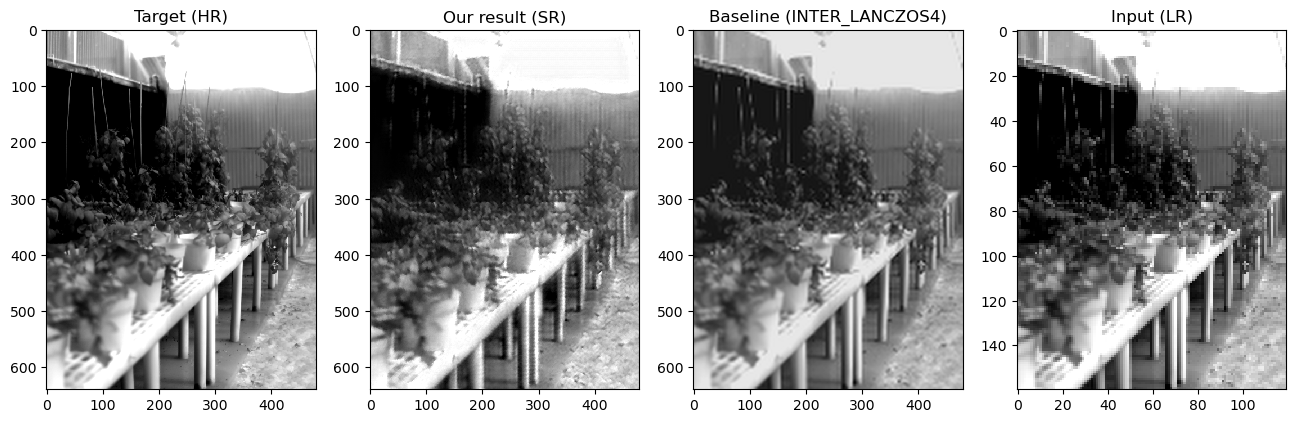

In [7]:
# Test Image
sample_dataset = ImageDataset(dataroot="/home/lion397/data/datasets/GEMINI/Training_All_221201/val/",
                                image_size=256, upscale_factor=4, mode="train")
(low_img, rgb_img, high_ir) = sample_dataset.getImage(-1)
# Resize
if 1:
    low_img = cv2.resize(high_ir,dsize=(0,0),fx=1/4, fy=1/4)


low_img = torch.FloatTensor(low_img)[None, None,:, :]/255.0
rgb_img = rgb_img[:, :, [2, 1, 0]] # swap channel from RGB to BGR
rgb_img = torch.FloatTensor(rgb_img).permute(2,0,1).unsqueeze(0)/255.0

high_ir = torch.FloatTensor(high_ir)[None, None,:, :]/255.0

lr = low_img.to(config.device, non_blocking=True)
rgb = rgb_img.to(config.device, non_blocking=True)
high_ir = high_ir.to(config.device, non_blocking=True)

sr = model(lr)

sr_img = sr.squeeze().cpu().detach().numpy()
lr_img = lr.squeeze().cpu().detach().numpy()
high_img = high_ir.squeeze().cpu().detach().numpy()
# plt.imshow(sr_img,cmap='gray')

#cv2.INTER_LANCZOS4
cv2.INTER_LINEAR
plot_result(high_img,sr_img,lr_img,baseline="INTER_LANCZOS4")

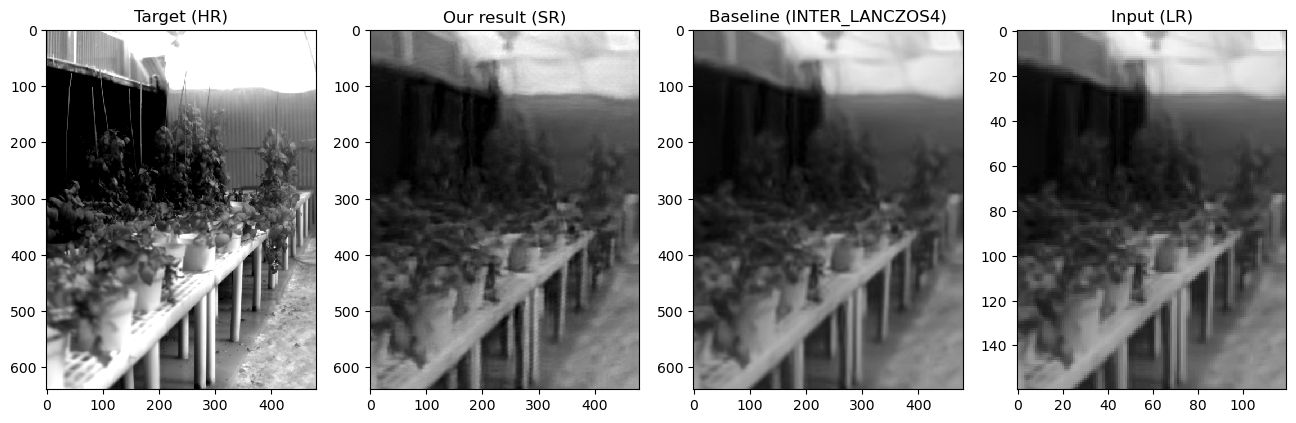

In [8]:
# Test Image
sample_dataset = ImageDataset(dataroot="/home/lion397/data/datasets/GEMINI/Training_All_221201/val/",
                                image_size=256, upscale_factor=4, mode="train")
(low_img, rgb_img, high_ir) = sample_dataset.getImage(-1)


low_img = torch.FloatTensor(low_img)[None, None,:, :]/255.0
rgb_img = rgb_img[:, :, [2, 1, 0]] # swap channel from RGB to BGR
rgb_img = torch.FloatTensor(rgb_img).permute(2,0,1).unsqueeze(0)/255.0

high_ir = torch.FloatTensor(high_ir)[None, None,:, :]/255.0

lr = low_img.to(config.device, non_blocking=True)
rgb = rgb_img.to(config.device, non_blocking=True)
high_ir = high_ir.to(config.device, non_blocking=True)

sr = model(lr)

sr_img = sr.squeeze().cpu().detach().numpy()
lr_img = lr.squeeze().cpu().detach().numpy()
high_img = high_ir.squeeze().cpu().detach().numpy()
# plt.imshow(sr_img,cmap='gray')

cv2.INTER_LANCZOS4
plot_result(high_img,sr_img,lr_img,baseline="INTER_LANCZOS4")

In [12]:
def create_dir(dir_):
    os.makedirs(dir_, exist_ok = True)
    
def process_dataset(dataroot, prefix, debug = False, write_img = True):
    # dataroot = "../../../datasets/GEMINI/2022-02-22-Greenhouse/"

    sr_dataroot_save = os.path.join(dataroot,"IR_ThermalRGB")
    create_dir(sr_dataroot_save)

    sample_dataset = ImageDataset(dataroot=dataroot,
                                image_size=96, upscale_factor=4, mode="train")

    for i in tqdm(range(len(sample_dataset.low_filenames))):
        (low_img, rgb_img, high_ir) = sample_dataset.getImage(i)

        low_img = torch.FloatTensor(low_img)[None, None,:, :]/255.0
        rgb_img = rgb_img[:, :, [2, 1, 0]] # swap channel from RGB to BGR
        rgb_img = torch.FloatTensor(rgb_img).permute(2,0,1).unsqueeze(0)/255.0

        high_ir = torch.FloatTensor(high_ir)[None, None,:, :]/255.0

        lr = low_img.to(config.device, non_blocking=True)
        rgb = rgb_img.to(config.device, non_blocking=True)
        high_ir = high_ir.to(config.device, non_blocking=True)

        sr = model(lr, rgb)

        sr_img = sr.squeeze().cpu().detach().numpy()
        lr_img = lr.squeeze().cpu().detach().numpy()
        high_img = high_ir.squeeze().cpu().detach().numpy()

        sr_name = '{prefix}_SR_480x640_{i:05d}.png'.format(prefix=prefix, i=i)

        if write_img:
            if 1:
                sr_img *= 255 # or any coefficient
                sr_img = sr_img.astype(np.uint8)
                cv2.imwrite(os.path.join(sr_dataroot_save,sr_name), sr_img)
            else:
                save_image(sr,os.path.join(sr_img,sr_name))

process_dataset(dataroot="/home/lion397/data/datasets/GEMINI/2022-04-05-Garbanzo/pairs_processed",prefix="220531_ThermalRGB",debug=False, write_img=True)

100%|██████████| 170/170 [00:08<00:00, 20.84it/s]
